<left><img src="https://i.ibb.co/zWjkHsWJ/marca-final-rgb-campanha-2025-versao02.png" width="35%" height="35%"></left>

# Tópicos em Matemática Aplicada: Deep Learning (Aula 07)

**Exemplo 2: Transfer Learning + Fine Tunning**

Data: 23/set/25


---

# Importando o que importa e escolha da GPU

In [ ]:
import torch                     # biblioteca principal de tensors e nn
import torch.nn as nn            # módulos de rede neural
import torch.optim as optim      # otimizadores (SGD, Adam, ...)
from torch.utils.data import DataLoader, Subset
import torchvision               # datasets, transformações e modelos pré‑treinados
from torchvision import transforms, datasets, models

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm           # barra de progresso bonita
import os, sys, time

# Detecta a GPU disponível
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("🟢 CUDA (GPU) disponível! Usando:", torch.cuda.get_device_name(0))
elif torch.backends.mps.is_available():
    # MPS = Metal Performance Shaders (GPU do Apple Silicon)
    device = torch.device('mps')
    print("🟢 MPS (GPU do Mac) disponível! Usando GPU via Metal.")
else:
    device = torch.device('cpu')
    print("⚪️  Nenhuma GPU encontrada. Usando CPU (pode ser lento).")

🟢 CUDA (GPU) disponível! Usando: NVIDIA A100-SXM4-40GB


# Transformações de dados e carregamento do CIFAR-10

In [ ]:
# Transformações para o conjunto de treino: aumentação + normalização
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),          # flip horizontal aleatório
    transforms.RandomCrop(32, padding=4),            # crop aleatório com padding
    transforms.ToTensor(),                           # converte para Tensor [0,1]
    transforms.Normalize((0.4914, 0.4822, 0.4465),   # média e desvio das 3 canais (CIFAR-10)
                         (0.2470, 0.2435, 0.2616)),  # esses valores são os que foram usados no IMAGENET
])

# Transformações para validação/teste: apenas normalização (sem aumentação)
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616)),
])

# Carrega o dataset CIFAR-10
import tempfile
data_dir = tempfile.mkdtemp()
train_set = datasets.CIFAR10(root=data_dir,
                             train=True,
                             download=True,
                             transform=transform_train)

val_set = datasets.CIFAR10(root=data_dir,
                           train=False,
                           download=True,
                           transform=transform_val)

# Número de classes
num_classes = len(train_set.classes)
print(f"Número de classes: {num_classes} -> {train_set.classes}")

# DataLoaders: iteram em batches, embaralham e paralelizam
batch_size = 128   # pode ser ajustado de acordo com a memória da GPU/CPU
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

100%|██████████| 170M/170M [00:31<00:00, 5.40MB/s]


Número de classes: 10 -> ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# Funções de Treinamento e avaliação

In [ ]:

def train_one_epoch(model, loader, criterion, optimizer, device):
    """
    Treina o modelo por UMA época (passa por todo o loader).
    Retorna a perda média e a acurácia (top-1) da época.
    """
    model.train()                # coloca o modelo em modo training (BatchNorm, Dropout, etc.)
    running_loss = 0.0
    correct = 0
    total = 0

    # tqdm para barra de progresso
    pbar = tqdm(enumerate(loader), total=len(loader), leave=False, desc='Train')
    for batch_idx, (inputs, targets) in pbar:
        inputs, targets = inputs.to(device), targets.to(device)  # move para GPU/CPU

        optimizer.zero_grad()            # zera gradientes acumulados
        outputs = model(inputs)          # forward pass
        loss = criterion(outputs, targets)
        loss.backward()                  # backward pass
        optimizer.step()                 # atualização dos pesos

        running_loss += loss.item() * inputs.size(0)

        # ---- cálculo da acurácia ----
        _, predicted = outputs.max(1)    # índice da classe com maior prob.
        total   += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # atualiza a barra com loss e acc
        pbar.set_postfix({'loss': running_loss/(batch_idx+1), 'acc': 100.*correct/total})

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc  = 100. * correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    """
    Avalia o modelo em um conjunto (val ou test) e devolve loss média e acurácia.
    """
    model.eval()                 # modo eval (desliga dropout, batchnorm em modo inference)
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():        # não computa gradientes -> mais rápido e menos memória
        pbar = tqdm(enumerate(loader), total=len(loader), leave=False, desc='Eval')
        for batch_idx, (inputs, targets) in pbar:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)

            _, predicted = outputs.max(1)
            total   += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            pbar.set_postfix({'loss': running_loss/(batch_idx+1), 'acc': 100.*correct/total})

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc  = 100. * correct / total
    return epoch_loss, epoch_acc

# Carrega um Modelo Pré-Treinado

Vamos usar uma ResNet-18 como modelo Pré-Treinado, cuja forma pode ser vista abaixo.

![](https://www.researchgate.net/publication/360470173/figure/fig5/AS:11431281211852519@1702495383312/Structure-of-the-ResNet-18-layer1d-a-The-basic-block-in-the-ResNet-18-layer-b-A.tif)

Usaremos os pesos da **ImageNet**. Mas, o que é? **ImageNet** é um grande banco de dados de imagens anotadas, criado para pesquisa em visão computacional. Algumas características importantes:

| Característica | Detalhes |
|----------------|----------|
| **Número de imagens** | Mais de 14 milhões de imagens (na sua versão completa). |
| **Número de categorias** | Aproximadamente 20.000 rótulos (por exemplo, "cachorro", "carro", "copo", etc.). |
| **Resolução** | Variável, mas tipicamente centenas de pixels em cada dimensão. |
| **Organização** | As imagens são organizadas segundo a hierarquia da WordNet (um léxico da língua inglesa). |
| **Desafio (ILSVRC)** | Desde 2010, a ImageNet Large Scale Visual Recognition Challenge (ILSVRC) usa um subconjunto de ~1,3 milhão de imagens em 1000 categorias para treinar e avaliar modelos. |

---

#### Transfer Learning vs. Fine Tuning

| Estratégia | O que fazemos com os pesos da ImageNet? |
|------------|------------------------------------------|
| **Transfer Learning (congelamento)** | Mantemos a maioria dos pesos **fixos** (não são atualizados durante o treinamento) e só treinamos a camada final (ou algumas camadas novas) para a nova tarefa. |
| **Fine Tuning** | Depois de treinar a camada final, **descongelamos** algumas camadas intermediárias (geralmente as mais altas) e continuamos o treinamento com um learning rate menor, permitindo que os pesos se ajustem ao novo domínio. |


In [ ]:
# Carrega o modelo pré-treinado (weights='IMAGENET1K_V1')
model = models.resnet18(weights='IMAGENET1K_V1')

# Congela todas as camadas (não queremos atualizar os pesos ainda)
for name, param in model.named_parameters():
    param.requires_grad = False     # gradientes não serão computados para esses parâmetros

# Substitui o classificador final:
# ResNet tem um atributo `fc` (fully connected) que normalmente tem 1000 saídas.
# Vamos trocar por uma camada Linear que tem `num_classes` saídas.
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Envia o modelo para a GPU escolhida
model = model.to(device)

# Verifica quantos parâmetros são treináveis (devem ser apenas o novo fc)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Parâmetros treináveis (apenas a nova camada): {trainable_params}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 244MB/s]


Parâmetros treináveis (apenas a nova camada): 5130


# Treina somente a camada nova (classificador)

In [ ]:
# Hiperparâmetros para esta fase
criterion = nn.CrossEntropyLoss()                # loss padrão para classificação multi-classe
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)  # apenas os pesos da camada fc
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)  # opcional, diminui LR

# Número de épocas
epochs_classifier = 10

# Listas para plotar loss/acc depois
train_losses, train_accs = [], []
val_losses,  val_accs    = [], []

for epoch in range(epochs_classifier):
    print(f"\nÉpoca {epoch+1}/{epochs_classifier} (treinando somente classificador)")

    # Treino
    loss_train, acc_train = train_one_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(loss_train); train_accs.append(acc_train)

    # Validação
    loss_val, acc_val = evaluate(model, val_loader, criterion, device)
    val_losses.append(loss_val); val_accs.append(acc_val)

    # Atualiza LR (se usar scheduler)
    scheduler.step()

    # Print resumo da época
    print(f"   Train loss: {loss_train:.4f}, Train acc: {acc_train:.2f}%")
    print(f"   Val   loss: {loss_val:.4f}, Val   acc: {acc_val:.2f}%")


Época 1/10 (treinando somente classificador)


   Train loss: 1.8641, Train acc: 34.20%
   Val   loss: 1.7835, Val   acc: 37.31%

Época 2/10 (treinando somente classificador)


   Train loss: 1.7133, Train acc: 40.08%
   Val   loss: 1.7281, Val   acc: 39.90%

Época 3/10 (treinando somente classificador)


   Train loss: 1.6945, Train acc: 40.55%
   Val   loss: 1.7100, Val   acc: 40.99%

Época 4/10 (treinando somente classificador)


   Train loss: 1.6775, Train acc: 40.98%
   Val   loss: 1.7258, Val   acc: 40.65%

Época 5/10 (treinando somente classificador)


   Train loss: 1.6710, Train acc: 41.63%
   Val   loss: 1.6969, Val   acc: 41.69%

Época 6/10 (treinando somente classificador)


   Train loss: 1.6577, Train acc: 42.08%
   Val   loss: 1.7007, Val   acc: 41.01%

Época 7/10 (treinando somente classificador)


   Train loss: 1.6521, Train acc: 41.93%
   Val   loss: 1.7013, Val   acc: 41.48%

Época 8/10 (treinando somente classificador)


   Train loss: 1.6522, Train acc: 42.42%
   Val   loss: 1.6729, Val   acc: 41.81%

Época 9/10 (treinando somente classificador)


   Train loss: 1.6438, Train acc: 42.66%
   Val   loss: 1.6848, Val   acc: 41.77%

Época 10/10 (treinando somente classificador)


   Train loss: 1.6427, Train acc: 42.58%
   Val   loss: 1.6779, Val   acc: 42.12%


# Descongela todos os parâmetros e faz o fine-tuning

In [ ]:

# Descongela tudo:
for param in model.parameters():
    param.requires_grad = True

# Optimizer para todos os parâmetros (lr menor que antes)
optimizer_ft = optim.Adam(model.parameters(), lr=1e-5)  # 1e-4 é um bom ponto de partida
scheduler_ft = optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=20)

epochs_finetune = 25

for epoch in range(epochs_finetune):
    print(f"\nÉpoca {epoch+1}/{epochs_finetune} (fine-tuning completo)")

    loss_train, acc_train = train_one_epoch(model, train_loader, criterion, optimizer_ft, device)
    loss_val,   acc_val   = evaluate(model, val_loader, criterion, device)

    scheduler_ft.step()

    # Opcional: guarda o melhor modelo
    if epoch == 0 or acc_val > max(val_accs):
        best_model_state = model.state_dict()
        print("Novo melhor modelo salvo!")

    # Append para visualização posterior
    train_losses.append(loss_train); train_accs.append(acc_train)
    val_losses.append(loss_val);     val_accs.append(acc_val)

    print(f"   Train loss: {loss_train:.4f}, Train acc: {acc_train:.2f}%")
    print(f"   Val   loss: {loss_val:.4f}, Val   acc: {acc_val:.2f}%")


Época 1/10 (fine-tuning completo)


Novo melhor modelo salvo!
   Train loss: 1.4855, Train acc: 47.95%
   Val   loss: 1.3604, Val   acc: 51.95%

Época 2/10 (fine-tuning completo)


Novo melhor modelo salvo!
   Train loss: 1.2788, Train acc: 54.84%
   Val   loss: 1.1986, Val   acc: 57.54%

Época 3/10 (fine-tuning completo)


Novo melhor modelo salvo!
   Train loss: 1.1558, Train acc: 59.66%
   Val   loss: 1.0941, Val   acc: 61.28%

Época 4/10 (fine-tuning completo)


Novo melhor modelo salvo!
   Train loss: 1.0727, Train acc: 62.25%
   Val   loss: 1.0098, Val   acc: 64.32%

Época 5/10 (fine-tuning completo)


Novo melhor modelo salvo!
   Train loss: 1.0044, Train acc: 64.72%
   Val   loss: 0.9543, Val   acc: 66.41%

Época 6/10 (fine-tuning completo)


Novo melhor modelo salvo!
   Train loss: 0.9455, Train acc: 66.81%
   Val   loss: 0.9147, Val   acc: 67.80%

Época 7/10 (fine-tuning completo)


Novo melhor modelo salvo!
   Train loss: 0.9146, Train acc: 67.95%
   Val   loss: 0.8726, Val   acc: 69.50%

Época 8/10 (fine-tuning completo)


Novo melhor modelo salvo!
   Train loss: 0.8755, Train acc: 69.36%
   Val   loss: 0.8463, Val   acc: 70.16%

Época 9/10 (fine-tuning completo)


Novo melhor modelo salvo!
   Train loss: 0.8506, Train acc: 69.98%
   Val   loss: 0.8280, Val   acc: 70.97%

Época 10/10 (fine-tuning completo)


Novo melhor modelo salvo!
   Train loss: 0.8249, Train acc: 71.05%
   Val   loss: 0.8151, Val   acc: 71.36%


# Avaliando as métricas

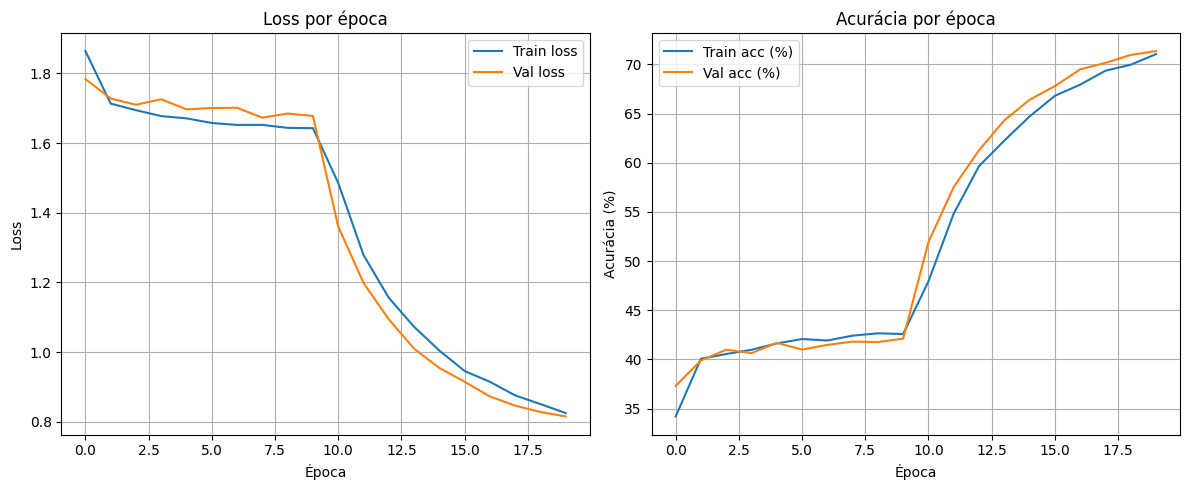

In [ ]:
def plot_history(train_losses, train_accs, val_losses, val_accs):
    plt.figure(figsize=(12,5))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train loss')
    plt.plot(val_losses,   label='Val loss')
    plt.title('Loss por época')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(train_accs, label='Train acc (%)')
    plt.plot(val_accs,   label='Val acc (%)')
    plt.title('Acurácia por época')
    plt.xlabel('Época')
    plt.ylabel('Acurácia (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Chama a função
plot_history(train_losses, train_accs, val_losses, val_accs)

# Salva o modelo treinado


In [ ]:

# Salva o estado completo (pesos, otimizador, epoch, etc.)
model_path = 'cifar10_resnet18_finetuned.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer_ft.state_dict(),
    'epoch': epochs_classifier + epochs_finetune,
    'val_acc': val_accs[-1]   # última acurácia de val
}, model_path)

print(f"Modelo salvo em: {model_path}")

# Se quiser carregar o modelo:

# checkpoint = torch.load(model_path, map_location=device)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer_ft.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# val_acc = checkpoint['val_acc']
# print(f"Modelo carregado: época {epoch}, val_acc {val_acc:.2f}%")

Modelo salvo em: cifar10_resnet18_finetuned.pth
